##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 14s

18284544/68606236 [======>.......................] - ETA: 2s 

25174016/68606236 [==========>...................] - ETA: 2s

39780352/68606236 [================>.............] - ETA: 1s

41951232/68606236 [=================>............] - ETA: 1s

56270848/68606236 [=======================>......] - ETA: 0s

68608000/68606236 [==============================] - 2s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

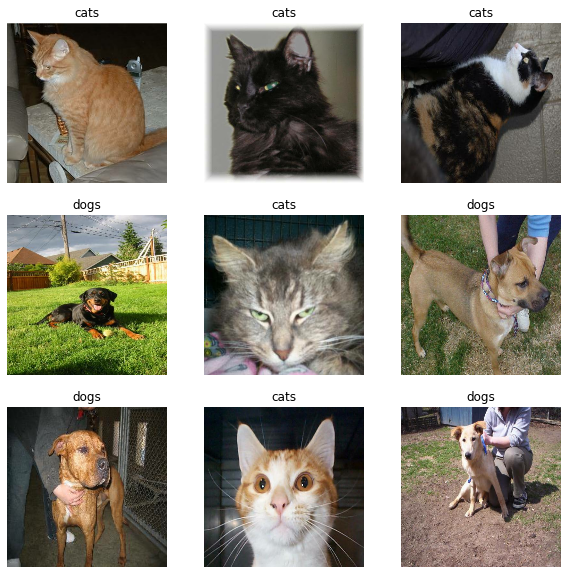

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

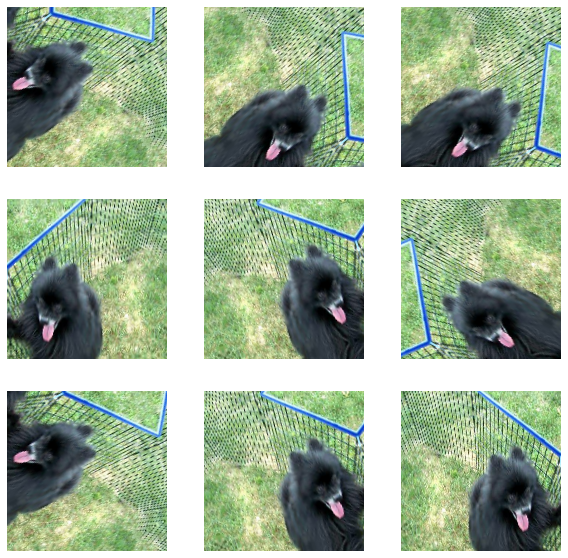

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

5521408/9406464 [================>.............] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 49s - loss: 0.8439 - accuracy: 0.4062

 4/26 [===>..........................] - ETA: 0s - loss: 0.8403 - accuracy: 0.4388 

 6/26 [=====>........................] - ETA: 0s - loss: 0.8377 - accuracy: 0.4415

 8/26 [========>.....................] - ETA: 0s - loss: 0.8380 - accuracy: 0.4420

10/26 [==========>...................] - ETA: 0s - loss: 0.8338 - accuracy: 0.4451

12/26 [============>.................] - ETA: 0s - loss: 0.8303 - accuracy: 0.4470

14/26 [===============>..............] - ETA: 0s - loss: 0.8269 - accuracy: 0.4486

16/26 [=================>............] - ETA: 0s - loss: 0.8254 - accuracy: 0.4499

18/26 [===================>..........] - ETA: 0s - loss: 0.8243 - accuracy: 0.4513

23/26 [=========================>....] - ETA: 0s - loss: 0.8210 - accuracy: 0.4540

26/26 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.4560

26/26 [==============================] - 3s 33ms/step - loss: 0.8183 - accuracy: 0.4566


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.47


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:57 - loss: 0.9126 - accuracy: 0.4375

 3/63 [>.............................] - ETA: 2s - loss: 0.8540 - accuracy: 0.5208  

 5/63 [=>............................] - ETA: 2s - loss: 0.8318 - accuracy: 0.5312

 7/63 [==>...........................] - ETA: 2s - loss: 0.7920 - accuracy: 0.5536

 9/63 [===>..........................] - ETA: 2s - loss: 0.7823 - accuracy: 0.5486

11/63 [====>.........................] - ETA: 2s - loss: 0.7741 - accuracy: 0.5455

13/63 [=====>........................] - ETA: 1s - loss: 0.7635 - accuracy: 0.5505

15/63 [======>.......................] - ETA: 1s - loss: 0.7759 - accuracy: 0.5417

17/63 [=======>......................] - ETA: 1s - loss: 0.7764 - accuracy: 0.5441

19/63 [========>.....................] - ETA: 1s - loss: 0.7847 - accuracy: 0.5395

21/63 [=========>....................] - ETA: 1s - loss: 0.7682 - accuracy: 0.5417

23/63 [=========>....................] - ETA: 1s - loss: 0.7622 - accuracy: 0.5394

25/63 [==========>...................] - ETA: 1s - loss: 0.7575 - accuracy: 0.5462

27/63 [===========>..................] - ETA: 1s - loss: 0.7516 - accuracy: 0.5451

29/63 [============>.................] - ETA: 1s - loss: 0.7508 - accuracy: 0.5474

31/63 [=============>................] - ETA: 1s - loss: 0.7441 - accuracy: 0.5524

33/63 [==============>...............] - ETA: 1s - loss: 0.7451 - accuracy: 0.5559

35/63 [===============>..............] - ETA: 1s - loss: 0.7405 - accuracy: 0.5598

37/63 [================>.............] - ETA: 1s - loss: 0.7349 - accuracy: 0.5617

39/63 [=================>............] - ETA: 0s - loss: 0.7356 - accuracy: 0.5633

41/63 [==================>...........] - ETA: 0s - loss: 0.7333 - accuracy: 0.5633

43/63 [===================>..........] - ETA: 0s - loss: 0.7253 - accuracy: 0.5669

45/63 [====================>.........] - ETA: 0s - loss: 0.7186 - accuracy: 0.5715

47/63 [=====================>........] - ETA: 0s - loss: 0.7167 - accuracy: 0.5711

49/63 [======================>.......] - ETA: 0s - loss: 0.7126 - accuracy: 0.5759

51/63 [=======================>......] - ETA: 0s - loss: 0.7116 - accuracy: 0.5766

53/63 [========================>.....] - ETA: 0s - loss: 0.7106 - accuracy: 0.5761

55/63 [=========================>....] - ETA: 0s - loss: 0.7086 - accuracy: 0.5773

59/63 [===========================>..] - ETA: 0s - loss: 0.6983 - accuracy: 0.5810

63/63 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5840

63/63 [==============================] - 7s 64ms/step - loss: 0.6962 - accuracy: 0.5840 - val_loss: 0.5437 - val_accuracy: 0.6708


Epoch 2/10


 1/63 [..............................] - ETA: 22s - loss: 0.5915 - accuracy: 0.7188

 3/63 [>.............................] - ETA: 2s - loss: 0.5791 - accuracy: 0.7083 

 5/63 [=>............................] - ETA: 2s - loss: 0.5630 - accuracy: 0.7125

 7/63 [==>...........................] - ETA: 2s - loss: 0.5516 - accuracy: 0.7188

 9/63 [===>..........................] - ETA: 1s - loss: 0.5307 - accuracy: 0.7257

11/63 [====>.........................] - ETA: 1s - loss: 0.5337 - accuracy: 0.7358

13/63 [=====>........................] - ETA: 1s - loss: 0.5461 - accuracy: 0.7236

15/63 [======>.......................] - ETA: 1s - loss: 0.5378 - accuracy: 0.7292

17/63 [=======>......................] - ETA: 1s - loss: 0.5402 - accuracy: 0.7206

19/63 [========>.....................] - ETA: 1s - loss: 0.5391 - accuracy: 0.7204

21/63 [=========>....................] - ETA: 1s - loss: 0.5413 - accuracy: 0.7158

23/63 [=========>....................] - ETA: 1s - loss: 0.5387 - accuracy: 0.7147

25/63 [==========>...................] - ETA: 1s - loss: 0.5354 - accuracy: 0.7150

27/63 [===========>..................] - ETA: 1s - loss: 0.5321 - accuracy: 0.7141

29/63 [============>.................] - ETA: 1s - loss: 0.5349 - accuracy: 0.7112

31/63 [=============>................] - ETA: 1s - loss: 0.5306 - accuracy: 0.7127

33/63 [==============>...............] - ETA: 1s - loss: 0.5272 - accuracy: 0.7178

35/63 [===============>..............] - ETA: 1s - loss: 0.5257 - accuracy: 0.7179

37/63 [================>.............] - ETA: 0s - loss: 0.5256 - accuracy: 0.7204

39/63 [=================>............] - ETA: 0s - loss: 0.5239 - accuracy: 0.7252

41/63 [==================>...........] - ETA: 0s - loss: 0.5240 - accuracy: 0.7248

43/63 [===================>..........] - ETA: 0s - loss: 0.5253 - accuracy: 0.7275

45/63 [====================>.........] - ETA: 0s - loss: 0.5213 - accuracy: 0.7292

47/63 [=====================>........] - ETA: 0s - loss: 0.5256 - accuracy: 0.7254

49/63 [======================>.......] - ETA: 0s - loss: 0.5235 - accuracy: 0.7270

51/63 [=======================>......] - ETA: 0s - loss: 0.5225 - accuracy: 0.7279

53/63 [========================>.....] - ETA: 0s - loss: 0.5203 - accuracy: 0.7294

55/63 [=========================>....] - ETA: 0s - loss: 0.5212 - accuracy: 0.7278

59/63 [===========================>..] - ETA: 0s - loss: 0.5198 - accuracy: 0.7256

63/63 [==============================] - 4s 55ms/step - loss: 0.5169 - accuracy: 0.7270 - val_loss: 0.4002 - val_accuracy: 0.8082


Epoch 3/10


 1/63 [..............................] - ETA: 20s - loss: 0.4307 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 2s - loss: 0.4723 - accuracy: 0.8021 

 5/63 [=>............................] - ETA: 2s - loss: 0.4645 - accuracy: 0.7812

 7/63 [==>...........................] - ETA: 2s - loss: 0.4621 - accuracy: 0.7679

 9/63 [===>..........................] - ETA: 2s - loss: 0.4624 - accuracy: 0.7778

11/63 [====>.........................] - ETA: 1s - loss: 0.4675 - accuracy: 0.7841

13/63 [=====>........................] - ETA: 1s - loss: 0.4656 - accuracy: 0.7837

15/63 [======>.......................] - ETA: 1s - loss: 0.4741 - accuracy: 0.7812

17/63 [=======>......................] - ETA: 1s - loss: 0.4646 - accuracy: 0.7831

19/63 [========>.....................] - ETA: 1s - loss: 0.4627 - accuracy: 0.7829

21/63 [=========>....................] - ETA: 1s - loss: 0.4494 - accuracy: 0.7976

23/63 [=========>....................] - ETA: 1s - loss: 0.4483 - accuracy: 0.7962

25/63 [==========>...................] - ETA: 1s - loss: 0.4505 - accuracy: 0.7912

27/63 [===========>..................] - ETA: 1s - loss: 0.4514 - accuracy: 0.7894

29/63 [============>.................] - ETA: 1s - loss: 0.4469 - accuracy: 0.7953

31/63 [=============>................] - ETA: 1s - loss: 0.4432 - accuracy: 0.7933

33/63 [==============>...............] - ETA: 1s - loss: 0.4357 - accuracy: 0.7955

35/63 [===============>..............] - ETA: 1s - loss: 0.4362 - accuracy: 0.7964

37/63 [================>.............] - ETA: 0s - loss: 0.4427 - accuracy: 0.7897

39/63 [=================>............] - ETA: 0s - loss: 0.4387 - accuracy: 0.7893

41/63 [==================>...........] - ETA: 0s - loss: 0.4407 - accuracy: 0.7858

43/63 [===================>..........] - ETA: 0s - loss: 0.4406 - accuracy: 0.7849

45/63 [====================>.........] - ETA: 0s - loss: 0.4360 - accuracy: 0.7903

47/63 [=====================>........] - ETA: 0s - loss: 0.4337 - accuracy: 0.7906

49/63 [======================>.......] - ETA: 0s - loss: 0.4342 - accuracy: 0.7927

51/63 [=======================>......] - ETA: 0s - loss: 0.4335 - accuracy: 0.7911

53/63 [========================>.....] - ETA: 0s - loss: 0.4308 - accuracy: 0.7925

55/63 [=========================>....] - ETA: 0s - loss: 0.4292 - accuracy: 0.7909

59/63 [===========================>..] - ETA: 0s - loss: 0.4275 - accuracy: 0.7929

63/63 [==============================] - 4s 54ms/step - loss: 0.4253 - accuracy: 0.7935 - val_loss: 0.3053 - val_accuracy: 0.8725


Epoch 4/10


 1/63 [..............................] - ETA: 20s - loss: 0.3686 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.4133 - accuracy: 0.8438 

 5/63 [=>............................] - ETA: 2s - loss: 0.3852 - accuracy: 0.8562

 7/63 [==>...........................] - ETA: 2s - loss: 0.3574 - accuracy: 0.8616

 9/63 [===>..........................] - ETA: 1s - loss: 0.3540 - accuracy: 0.8542

11/63 [====>.........................] - ETA: 1s - loss: 0.3541 - accuracy: 0.8580

13/63 [=====>........................] - ETA: 1s - loss: 0.3526 - accuracy: 0.8582

15/63 [======>.......................] - ETA: 1s - loss: 0.3701 - accuracy: 0.8479

17/63 [=======>......................] - ETA: 1s - loss: 0.3695 - accuracy: 0.8493

19/63 [========>.....................] - ETA: 1s - loss: 0.3724 - accuracy: 0.8421

21/63 [=========>....................] - ETA: 1s - loss: 0.3695 - accuracy: 0.8423

23/63 [=========>....................] - ETA: 1s - loss: 0.3685 - accuracy: 0.8451

25/63 [==========>...................] - ETA: 1s - loss: 0.3854 - accuracy: 0.8300

27/63 [===========>..................] - ETA: 1s - loss: 0.3831 - accuracy: 0.8333

29/63 [============>.................] - ETA: 1s - loss: 0.3775 - accuracy: 0.8373

31/63 [=============>................] - ETA: 1s - loss: 0.3713 - accuracy: 0.8387

33/63 [==============>...............] - ETA: 1s - loss: 0.3709 - accuracy: 0.8362

35/63 [===============>..............] - ETA: 0s - loss: 0.3740 - accuracy: 0.8339

37/63 [================>.............] - ETA: 0s - loss: 0.3733 - accuracy: 0.8336

39/63 [=================>............] - ETA: 0s - loss: 0.3719 - accuracy: 0.8357

41/63 [==================>...........] - ETA: 0s - loss: 0.3729 - accuracy: 0.8346

43/63 [===================>..........] - ETA: 0s - loss: 0.3706 - accuracy: 0.8350

45/63 [====================>.........] - ETA: 0s - loss: 0.3687 - accuracy: 0.8375

47/63 [=====================>........] - ETA: 0s - loss: 0.3695 - accuracy: 0.8358

49/63 [======================>.......] - ETA: 0s - loss: 0.3672 - accuracy: 0.8380

51/63 [=======================>......] - ETA: 0s - loss: 0.3661 - accuracy: 0.8382

53/63 [========================>.....] - ETA: 0s - loss: 0.3654 - accuracy: 0.8384

55/63 [=========================>....] - ETA: 0s - loss: 0.3638 - accuracy: 0.8375

59/63 [===========================>..] - ETA: 0s - loss: 0.3601 - accuracy: 0.8379

63/63 [==============================] - 4s 52ms/step - loss: 0.3604 - accuracy: 0.8365 - val_loss: 0.2515 - val_accuracy: 0.9047


Epoch 5/10


 1/63 [..............................] - ETA: 19s - loss: 0.3953 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 2s - loss: 0.3103 - accuracy: 0.8854 

 5/63 [=>............................] - ETA: 2s - loss: 0.3397 - accuracy: 0.8562

 7/63 [==>...........................] - ETA: 2s - loss: 0.3437 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 1s - loss: 0.3576 - accuracy: 0.8403

11/63 [====>.........................] - ETA: 1s - loss: 0.3516 - accuracy: 0.8438

13/63 [=====>........................] - ETA: 1s - loss: 0.3327 - accuracy: 0.8582

15/63 [======>.......................] - ETA: 1s - loss: 0.3395 - accuracy: 0.8500

17/63 [=======>......................] - ETA: 1s - loss: 0.3431 - accuracy: 0.8456

19/63 [========>.....................] - ETA: 1s - loss: 0.3341 - accuracy: 0.8553

21/63 [=========>....................] - ETA: 1s - loss: 0.3332 - accuracy: 0.8557

23/63 [=========>....................] - ETA: 1s - loss: 0.3307 - accuracy: 0.8587

25/63 [==========>...................] - ETA: 1s - loss: 0.3242 - accuracy: 0.8587

27/63 [===========>..................] - ETA: 1s - loss: 0.3211 - accuracy: 0.8611

29/63 [============>.................] - ETA: 1s - loss: 0.3243 - accuracy: 0.8599

31/63 [=============>................] - ETA: 1s - loss: 0.3233 - accuracy: 0.8599

33/63 [==============>...............] - ETA: 1s - loss: 0.3253 - accuracy: 0.8580

35/63 [===============>..............] - ETA: 0s - loss: 0.3311 - accuracy: 0.8562

37/63 [================>.............] - ETA: 0s - loss: 0.3285 - accuracy: 0.8573

39/63 [=================>............] - ETA: 0s - loss: 0.3260 - accuracy: 0.8598

41/63 [==================>...........] - ETA: 0s - loss: 0.3245 - accuracy: 0.8605

43/63 [===================>..........] - ETA: 0s - loss: 0.3222 - accuracy: 0.8612

45/63 [====================>.........] - ETA: 0s - loss: 0.3247 - accuracy: 0.8576

47/63 [=====================>........] - ETA: 0s - loss: 0.3231 - accuracy: 0.8590

49/63 [======================>.......] - ETA: 0s - loss: 0.3250 - accuracy: 0.8584

51/63 [=======================>......] - ETA: 0s - loss: 0.3301 - accuracy: 0.8523

53/63 [========================>.....] - ETA: 0s - loss: 0.3299 - accuracy: 0.8520

55/63 [=========================>....] - ETA: 0s - loss: 0.3277 - accuracy: 0.8523

60/63 [===========================>..] - ETA: 0s - loss: 0.3236 - accuracy: 0.8542

63/63 [==============================] - 3s 51ms/step - loss: 0.3200 - accuracy: 0.8565 - val_loss: 0.2226 - val_accuracy: 0.9183


Epoch 6/10


 1/63 [..............................] - ETA: 18s - loss: 0.3047 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.2698 - accuracy: 0.8958 

 5/63 [=>............................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.2860 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.2995 - accuracy: 0.8576

11/63 [====>.........................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8580

13/63 [=====>........................] - ETA: 1s - loss: 0.2954 - accuracy: 0.8558

15/63 [======>.......................] - ETA: 1s - loss: 0.3000 - accuracy: 0.8500

17/63 [=======>......................] - ETA: 1s - loss: 0.2935 - accuracy: 0.8548

19/63 [========>.....................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8602

21/63 [=========>....................] - ETA: 1s - loss: 0.2869 - accuracy: 0.8646

23/63 [=========>....................] - ETA: 1s - loss: 0.2886 - accuracy: 0.8682

25/63 [==========>...................] - ETA: 1s - loss: 0.2966 - accuracy: 0.8662

27/63 [===========>..................] - ETA: 1s - loss: 0.2911 - accuracy: 0.8681

29/63 [============>.................] - ETA: 1s - loss: 0.2861 - accuracy: 0.8718

31/63 [=============>................] - ETA: 1s - loss: 0.2867 - accuracy: 0.8710

33/63 [==============>...............] - ETA: 1s - loss: 0.2852 - accuracy: 0.8722

35/63 [===============>..............] - ETA: 0s - loss: 0.2881 - accuracy: 0.8705

37/63 [================>.............] - ETA: 0s - loss: 0.2875 - accuracy: 0.8699

39/63 [=================>............] - ETA: 0s - loss: 0.2855 - accuracy: 0.8702

41/63 [==================>...........] - ETA: 0s - loss: 0.2848 - accuracy: 0.8712

43/63 [===================>..........] - ETA: 0s - loss: 0.2817 - accuracy: 0.8728

45/63 [====================>.........] - ETA: 0s - loss: 0.2814 - accuracy: 0.8722

47/63 [=====================>........] - ETA: 0s - loss: 0.2824 - accuracy: 0.8730

49/63 [======================>.......] - ETA: 0s - loss: 0.2819 - accuracy: 0.8731

51/63 [=======================>......] - ETA: 0s - loss: 0.2791 - accuracy: 0.8744

53/63 [========================>.....] - ETA: 0s - loss: 0.2783 - accuracy: 0.8762

55/63 [=========================>....] - ETA: 0s - loss: 0.2791 - accuracy: 0.8739

59/63 [===========================>..] - ETA: 0s - loss: 0.2761 - accuracy: 0.8771

63/63 [==============================] - 3s 51ms/step - loss: 0.2788 - accuracy: 0.8750 - val_loss: 0.1887 - val_accuracy: 0.9356


Epoch 7/10


 1/63 [..............................] - ETA: 20s - loss: 0.2089 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8958 

 5/63 [=>............................] - ETA: 2s - loss: 0.2875 - accuracy: 0.9000

 7/63 [==>...........................] - ETA: 1s - loss: 0.2820 - accuracy: 0.8884

 9/63 [===>..........................] - ETA: 1s - loss: 0.2732 - accuracy: 0.8889

11/63 [====>.........................] - ETA: 1s - loss: 0.2636 - accuracy: 0.8920

13/63 [=====>........................] - ETA: 1s - loss: 0.2702 - accuracy: 0.8894

15/63 [======>.......................] - ETA: 1s - loss: 0.2654 - accuracy: 0.8917

17/63 [=======>......................] - ETA: 1s - loss: 0.2659 - accuracy: 0.8879

19/63 [========>.....................] - ETA: 1s - loss: 0.2673 - accuracy: 0.8882

21/63 [=========>....................] - ETA: 1s - loss: 0.2636 - accuracy: 0.8869

23/63 [=========>....................] - ETA: 1s - loss: 0.2618 - accuracy: 0.8845

25/63 [==========>...................] - ETA: 1s - loss: 0.2578 - accuracy: 0.8850

27/63 [===========>..................] - ETA: 1s - loss: 0.2601 - accuracy: 0.8843

29/63 [============>.................] - ETA: 1s - loss: 0.2720 - accuracy: 0.8750

31/63 [=============>................] - ETA: 1s - loss: 0.2721 - accuracy: 0.8770

33/63 [==============>...............] - ETA: 1s - loss: 0.2678 - accuracy: 0.8816

35/63 [===============>..............] - ETA: 0s - loss: 0.2679 - accuracy: 0.8848

37/63 [================>.............] - ETA: 0s - loss: 0.2696 - accuracy: 0.8809

39/63 [=================>............] - ETA: 0s - loss: 0.2680 - accuracy: 0.8822

41/63 [==================>...........] - ETA: 0s - loss: 0.2658 - accuracy: 0.8841

43/63 [===================>..........] - ETA: 0s - loss: 0.2655 - accuracy: 0.8830

45/63 [====================>.........] - ETA: 0s - loss: 0.2634 - accuracy: 0.8833

47/63 [=====================>........] - ETA: 0s - loss: 0.2646 - accuracy: 0.8823

49/63 [======================>.......] - ETA: 0s - loss: 0.2662 - accuracy: 0.8814

51/63 [=======================>......] - ETA: 0s - loss: 0.2656 - accuracy: 0.8824

53/63 [========================>.....] - ETA: 0s - loss: 0.2652 - accuracy: 0.8833

55/63 [=========================>....] - ETA: 0s - loss: 0.2622 - accuracy: 0.8847

59/63 [===========================>..] - ETA: 0s - loss: 0.2621 - accuracy: 0.8856

63/63 [==============================] - 4s 51ms/step - loss: 0.2579 - accuracy: 0.8895 - val_loss: 0.1682 - val_accuracy: 0.9418


Epoch 8/10


 1/63 [..............................] - ETA: 20s - loss: 0.1930 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.2369 - accuracy: 0.8854 

 5/63 [=>............................] - ETA: 2s - loss: 0.2288 - accuracy: 0.8875

 7/63 [==>...........................] - ETA: 1s - loss: 0.2298 - accuracy: 0.8973

 9/63 [===>..........................] - ETA: 1s - loss: 0.2379 - accuracy: 0.9028

11/63 [====>.........................] - ETA: 1s - loss: 0.2516 - accuracy: 0.8977

13/63 [=====>........................] - ETA: 1s - loss: 0.2418 - accuracy: 0.9014

15/63 [======>.......................] - ETA: 1s - loss: 0.2542 - accuracy: 0.8875

17/63 [=======>......................] - ETA: 1s - loss: 0.2521 - accuracy: 0.8934

19/63 [========>.....................] - ETA: 1s - loss: 0.2530 - accuracy: 0.8914

21/63 [=========>....................] - ETA: 1s - loss: 0.2496 - accuracy: 0.8914

23/63 [=========>....................] - ETA: 1s - loss: 0.2502 - accuracy: 0.8927

25/63 [==========>...................] - ETA: 1s - loss: 0.2502 - accuracy: 0.8925

27/63 [===========>..................] - ETA: 1s - loss: 0.2556 - accuracy: 0.8889

29/63 [============>.................] - ETA: 1s - loss: 0.2571 - accuracy: 0.8869

31/63 [=============>................] - ETA: 1s - loss: 0.2524 - accuracy: 0.8901

33/63 [==============>...............] - ETA: 1s - loss: 0.2545 - accuracy: 0.8845

35/63 [===============>..............] - ETA: 0s - loss: 0.2567 - accuracy: 0.8830

37/63 [================>.............] - ETA: 0s - loss: 0.2567 - accuracy: 0.8834

39/63 [=================>............] - ETA: 0s - loss: 0.2566 - accuracy: 0.8814

41/63 [==================>...........] - ETA: 0s - loss: 0.2589 - accuracy: 0.8826

43/63 [===================>..........] - ETA: 0s - loss: 0.2552 - accuracy: 0.8852

45/63 [====================>.........] - ETA: 0s - loss: 0.2526 - accuracy: 0.8854

47/63 [=====================>........] - ETA: 0s - loss: 0.2541 - accuracy: 0.8836

49/63 [======================>.......] - ETA: 0s - loss: 0.2549 - accuracy: 0.8820

51/63 [=======================>......] - ETA: 0s - loss: 0.2558 - accuracy: 0.8799

53/63 [========================>.....] - ETA: 0s - loss: 0.2553 - accuracy: 0.8803

55/63 [=========================>....] - ETA: 0s - loss: 0.2556 - accuracy: 0.8807

60/63 [===========================>..] - ETA: 0s - loss: 0.2552 - accuracy: 0.8802

63/63 [==============================] - 4s 51ms/step - loss: 0.2536 - accuracy: 0.8815 - val_loss: 0.1554 - val_accuracy: 0.9468


Epoch 9/10


 1/63 [..............................] - ETA: 19s - loss: 0.2120 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.2199 - accuracy: 0.9271 

 5/63 [=>............................] - ETA: 2s - loss: 0.2098 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 2s - loss: 0.2238 - accuracy: 0.8973

 9/63 [===>..........................] - ETA: 1s - loss: 0.2476 - accuracy: 0.8958

11/63 [====>.........................] - ETA: 1s - loss: 0.2357 - accuracy: 0.9062

13/63 [=====>........................] - ETA: 1s - loss: 0.2336 - accuracy: 0.9062

15/63 [======>.......................] - ETA: 1s - loss: 0.2315 - accuracy: 0.9083

17/63 [=======>......................] - ETA: 1s - loss: 0.2305 - accuracy: 0.9081

19/63 [========>.....................] - ETA: 1s - loss: 0.2293 - accuracy: 0.9095

21/63 [=========>....................] - ETA: 1s - loss: 0.2361 - accuracy: 0.9033

23/63 [=========>....................] - ETA: 1s - loss: 0.2336 - accuracy: 0.9049

25/63 [==========>...................] - ETA: 1s - loss: 0.2304 - accuracy: 0.9087

27/63 [===========>..................] - ETA: 1s - loss: 0.2344 - accuracy: 0.9062

29/63 [============>.................] - ETA: 1s - loss: 0.2355 - accuracy: 0.9041

31/63 [=============>................] - ETA: 1s - loss: 0.2334 - accuracy: 0.9042

33/63 [==============>...............] - ETA: 1s - loss: 0.2409 - accuracy: 0.8958

35/63 [===============>..............] - ETA: 1s - loss: 0.2423 - accuracy: 0.8946

37/63 [================>.............] - ETA: 0s - loss: 0.2437 - accuracy: 0.8961

39/63 [=================>............] - ETA: 0s - loss: 0.2421 - accuracy: 0.8966

41/63 [==================>...........] - ETA: 0s - loss: 0.2386 - accuracy: 0.8994

43/63 [===================>..........] - ETA: 0s - loss: 0.2380 - accuracy: 0.9004

45/63 [====================>.........] - ETA: 0s - loss: 0.2345 - accuracy: 0.9021

47/63 [=====================>........] - ETA: 0s - loss: 0.2341 - accuracy: 0.9023

49/63 [======================>.......] - ETA: 0s - loss: 0.2350 - accuracy: 0.9018

51/63 [=======================>......] - ETA: 0s - loss: 0.2338 - accuracy: 0.9007

53/63 [========================>.....] - ETA: 0s - loss: 0.2308 - accuracy: 0.9009

55/63 [=========================>....] - ETA: 0s - loss: 0.2319 - accuracy: 0.9011

59/63 [===========================>..] - ETA: 0s - loss: 0.2274 - accuracy: 0.9047

63/63 [==============================] - 4s 53ms/step - loss: 0.2240 - accuracy: 0.9080 - val_loss: 0.1410 - val_accuracy: 0.9468


Epoch 10/10


 1/63 [..............................] - ETA: 20s - loss: 0.2253 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.2073 - accuracy: 0.9167 

 5/63 [=>............................] - ETA: 2s - loss: 0.2097 - accuracy: 0.9125

 7/63 [==>...........................] - ETA: 2s - loss: 0.2101 - accuracy: 0.9152

 9/63 [===>..........................] - ETA: 1s - loss: 0.2002 - accuracy: 0.9236

11/63 [====>.........................] - ETA: 1s - loss: 0.2083 - accuracy: 0.9205

13/63 [=====>........................] - ETA: 1s - loss: 0.2176 - accuracy: 0.9159

15/63 [======>.......................] - ETA: 1s - loss: 0.2347 - accuracy: 0.9042

17/63 [=======>......................] - ETA: 1s - loss: 0.2224 - accuracy: 0.9118

19/63 [========>.....................] - ETA: 1s - loss: 0.2189 - accuracy: 0.9128

21/63 [=========>....................] - ETA: 1s - loss: 0.2250 - accuracy: 0.9062

23/63 [=========>....................] - ETA: 1s - loss: 0.2259 - accuracy: 0.9049

25/63 [==========>...................] - ETA: 1s - loss: 0.2238 - accuracy: 0.9025

27/63 [===========>..................] - ETA: 1s - loss: 0.2243 - accuracy: 0.9016

29/63 [============>.................] - ETA: 1s - loss: 0.2248 - accuracy: 0.8998

31/63 [=============>................] - ETA: 1s - loss: 0.2214 - accuracy: 0.9022

33/63 [==============>...............] - ETA: 1s - loss: 0.2219 - accuracy: 0.8996

35/63 [===============>..............] - ETA: 1s - loss: 0.2208 - accuracy: 0.9000

37/63 [================>.............] - ETA: 0s - loss: 0.2185 - accuracy: 0.8995

39/63 [=================>............] - ETA: 0s - loss: 0.2193 - accuracy: 0.8974

41/63 [==================>...........] - ETA: 0s - loss: 0.2203 - accuracy: 0.8979

43/63 [===================>..........] - ETA: 0s - loss: 0.2167 - accuracy: 0.9012

45/63 [====================>.........] - ETA: 0s - loss: 0.2209 - accuracy: 0.8986

47/63 [=====================>........] - ETA: 0s - loss: 0.2167 - accuracy: 0.9016

49/63 [======================>.......] - ETA: 0s - loss: 0.2154 - accuracy: 0.9024

51/63 [=======================>......] - ETA: 0s - loss: 0.2161 - accuracy: 0.9013

53/63 [========================>.....] - ETA: 0s - loss: 0.2154 - accuracy: 0.9015

55/63 [=========================>....] - ETA: 0s - loss: 0.2155 - accuracy: 0.9011

60/63 [===========================>..] - ETA: 0s - loss: 0.2155 - accuracy: 0.9010

63/63 [==============================] - 4s 53ms/step - loss: 0.2158 - accuracy: 0.9005 - val_loss: 0.1345 - val_accuracy: 0.9493


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

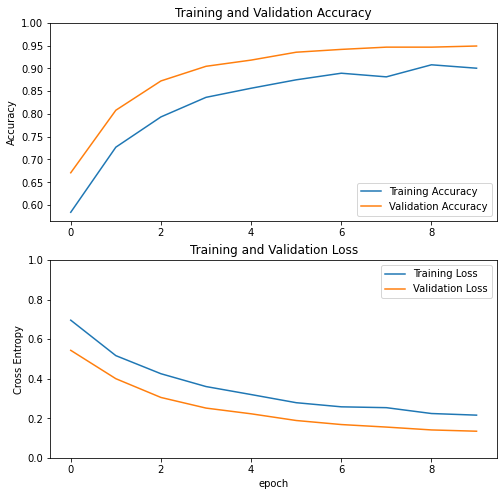

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:25 - loss: 0.1603 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.1550 - accuracy: 0.9427  

 5/63 [=>............................] - ETA: 2s - loss: 0.1529 - accuracy: 0.9434

 7/63 [==>...........................] - ETA: 1s - loss: 0.1572 - accuracy: 0.9425

 9/63 [===>..........................] - ETA: 1s - loss: 0.1661 - accuracy: 0.9381

11/63 [====>.........................] - ETA: 1s - loss: 0.1704 - accuracy: 0.9359

13/63 [=====>........................] - ETA: 1s - loss: 0.1756 - accuracy: 0.9334

15/63 [======>.......................] - ETA: 1s - loss: 0.1798 - accuracy: 0.9311

17/63 [=======>......................] - ETA: 1s - loss: 0.1826 - accuracy: 0.9296

19/63 [========>.....................] - ETA: 1s - loss: 0.1843 - accuracy: 0.9286

21/63 [=========>....................] - ETA: 1s - loss: 0.1853 - accuracy: 0.9277

23/63 [=========>....................] - ETA: 1s - loss: 0.1860 - accuracy: 0.9273

25/63 [==========>...................] - ETA: 1s - loss: 0.1865 - accuracy: 0.9270

27/63 [===========>..................] - ETA: 1s - loss: 0.1873 - accuracy: 0.9265

29/63 [============>.................] - ETA: 1s - loss: 0.1879 - accuracy: 0.9260

31/63 [=============>................] - ETA: 1s - loss: 0.1882 - accuracy: 0.9257

33/63 [==============>...............] - ETA: 1s - loss: 0.1882 - accuracy: 0.9255

35/63 [===============>..............] - ETA: 1s - loss: 0.1878 - accuracy: 0.9255

37/63 [================>.............] - ETA: 0s - loss: 0.1875 - accuracy: 0.9254

39/63 [=================>............] - ETA: 0s - loss: 0.1870 - accuracy: 0.9255

41/63 [==================>...........] - ETA: 0s - loss: 0.1867 - accuracy: 0.9255

43/63 [===================>..........] - ETA: 0s - loss: 0.1865 - accuracy: 0.9256

45/63 [====================>.........] - ETA: 0s - loss: 0.1860 - accuracy: 0.9258

47/63 [=====================>........] - ETA: 0s - loss: 0.1854 - accuracy: 0.9260

49/63 [======================>.......] - ETA: 0s - loss: 0.1847 - accuracy: 0.9263

51/63 [=======================>......] - ETA: 0s - loss: 0.1840 - accuracy: 0.9266

53/63 [========================>.....] - ETA: 0s - loss: 0.1833 - accuracy: 0.9269

55/63 [=========================>....] - ETA: 0s - loss: 0.1826 - accuracy: 0.9271

58/63 [==========================>...] - ETA: 0s - loss: 0.1816 - accuracy: 0.9275

61/63 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9278

63/63 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9280

63/63 [==============================] - 9s 69ms/step - loss: 0.1798 - accuracy: 0.9281 - val_loss: 0.0650 - val_accuracy: 0.9752


Epoch 11/20


 1/63 [..............................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1238 - accuracy: 0.9340 

 5/63 [=>............................] - ETA: 2s - loss: 0.1325 - accuracy: 0.9339

 7/63 [==>...........................] - ETA: 2s - loss: 0.1351 - accuracy: 0.9364

 9/63 [===>..........................] - ETA: 1s - loss: 0.1378 - accuracy: 0.9366

11/63 [====>.........................] - ETA: 1s - loss: 0.1379 - accuracy: 0.9365

13/63 [=====>........................] - ETA: 1s - loss: 0.1372 - accuracy: 0.9367

15/63 [======>.......................] - ETA: 1s - loss: 0.1362 - accuracy: 0.9372

17/63 [=======>......................] - ETA: 1s - loss: 0.1354 - accuracy: 0.9378

19/63 [========>.....................] - ETA: 1s - loss: 0.1353 - accuracy: 0.9382

21/63 [=========>....................] - ETA: 1s - loss: 0.1349 - accuracy: 0.9389

23/63 [=========>....................] - ETA: 1s - loss: 0.1340 - accuracy: 0.9397

25/63 [==========>...................] - ETA: 1s - loss: 0.1335 - accuracy: 0.9403

27/63 [===========>..................] - ETA: 1s - loss: 0.1332 - accuracy: 0.9408

29/63 [============>.................] - ETA: 1s - loss: 0.1330 - accuracy: 0.9411

31/63 [=============>................] - ETA: 1s - loss: 0.1327 - accuracy: 0.9416

33/63 [==============>...............] - ETA: 1s - loss: 0.1323 - accuracy: 0.9420

35/63 [===============>..............] - ETA: 1s - loss: 0.1319 - accuracy: 0.9425

37/63 [================>.............] - ETA: 0s - loss: 0.1314 - accuracy: 0.9429

39/63 [=================>............] - ETA: 0s - loss: 0.1310 - accuracy: 0.9433

41/63 [==================>...........] - ETA: 0s - loss: 0.1307 - accuracy: 0.9437

43/63 [===================>..........] - ETA: 0s - loss: 0.1303 - accuracy: 0.9440

45/63 [====================>.........] - ETA: 0s - loss: 0.1301 - accuracy: 0.9442

47/63 [=====================>........] - ETA: 0s - loss: 0.1298 - accuracy: 0.9444

49/63 [======================>.......] - ETA: 0s - loss: 0.1296 - accuracy: 0.9445

51/63 [=======================>......] - ETA: 0s - loss: 0.1294 - accuracy: 0.9446

53/63 [========================>.....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9448

55/63 [=========================>....] - ETA: 0s - loss: 0.1290 - accuracy: 0.9449

58/63 [==========================>...] - ETA: 0s - loss: 0.1288 - accuracy: 0.9450

61/63 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9451

63/63 [==============================] - 4s 55ms/step - loss: 0.1283 - accuracy: 0.9453 - val_loss: 0.0519 - val_accuracy: 0.9827


Epoch 12/20


 1/63 [..............................] - ETA: 20s - loss: 0.0054 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0328 - accuracy: 0.9844 

 5/63 [=>............................] - ETA: 2s - loss: 0.0522 - accuracy: 0.9781

 7/63 [==>...........................] - ETA: 2s - loss: 0.0637 - accuracy: 0.9748

 9/63 [===>..........................] - ETA: 1s - loss: 0.0731 - accuracy: 0.9715

11/63 [====>.........................] - ETA: 1s - loss: 0.0804 - accuracy: 0.9685

13/63 [=====>........................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9670

15/63 [======>.......................] - ETA: 1s - loss: 0.0880 - accuracy: 0.9653

17/63 [=======>......................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9634

19/63 [========>.....................] - ETA: 1s - loss: 0.0938 - accuracy: 0.9621

21/63 [=========>....................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9609

23/63 [=========>....................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9595

25/63 [==========>...................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9582

27/63 [===========>..................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9572

29/63 [============>.................] - ETA: 1s - loss: 0.1044 - accuracy: 0.9564

31/63 [=============>................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9558

33/63 [==============>...............] - ETA: 1s - loss: 0.1068 - accuracy: 0.9552

35/63 [===============>..............] - ETA: 1s - loss: 0.1079 - accuracy: 0.9547

37/63 [================>.............] - ETA: 0s - loss: 0.1089 - accuracy: 0.9543

39/63 [=================>............] - ETA: 0s - loss: 0.1097 - accuracy: 0.9540

41/63 [==================>...........] - ETA: 0s - loss: 0.1103 - accuracy: 0.9538

43/63 [===================>..........] - ETA: 0s - loss: 0.1107 - accuracy: 0.9536

45/63 [====================>.........] - ETA: 0s - loss: 0.1111 - accuracy: 0.9535

47/63 [=====================>........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9534

49/63 [======================>.......] - ETA: 0s - loss: 0.1114 - accuracy: 0.9533

51/63 [=======================>......] - ETA: 0s - loss: 0.1115 - accuracy: 0.9533

53/63 [========================>.....] - ETA: 0s - loss: 0.1116 - accuracy: 0.9533

55/63 [=========================>....] - ETA: 0s - loss: 0.1116 - accuracy: 0.9534

58/63 [==========================>...] - ETA: 0s - loss: 0.1116 - accuracy: 0.9534

61/63 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9535

63/63 [==============================] - 4s 55ms/step - loss: 0.1112 - accuracy: 0.9536 - val_loss: 0.0463 - val_accuracy: 0.9777


Epoch 13/20


 1/63 [..............................] - ETA: 22s - loss: 0.0071 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0151 - accuracy: 0.9931 

 5/63 [=>............................] - ETA: 2s - loss: 0.0229 - accuracy: 0.9902

 7/63 [==>...........................] - ETA: 2s - loss: 0.0363 - accuracy: 0.9862

 9/63 [===>..........................] - ETA: 1s - loss: 0.0493 - accuracy: 0.9808

11/63 [====>.........................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9770

13/63 [=====>........................] - ETA: 1s - loss: 0.0665 - accuracy: 0.9736

15/63 [======>.......................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9714

17/63 [=======>......................] - ETA: 1s - loss: 0.0778 - accuracy: 0.9696

19/63 [========>.....................] - ETA: 1s - loss: 0.0823 - accuracy: 0.9682

21/63 [=========>....................] - ETA: 1s - loss: 0.0855 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 1s - loss: 0.0881 - accuracy: 0.9666

25/63 [==========>...................] - ETA: 1s - loss: 0.0905 - accuracy: 0.9660

27/63 [===========>..................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9655

29/63 [============>.................] - ETA: 1s - loss: 0.0936 - accuracy: 0.9653

31/63 [=============>................] - ETA: 1s - loss: 0.0943 - accuracy: 0.9653

33/63 [==============>...............] - ETA: 1s - loss: 0.0947 - accuracy: 0.9654

35/63 [===============>..............] - ETA: 1s - loss: 0.0949 - accuracy: 0.9656

37/63 [================>.............] - ETA: 0s - loss: 0.0952 - accuracy: 0.9657

39/63 [=================>............] - ETA: 0s - loss: 0.0955 - accuracy: 0.9657

41/63 [==================>...........] - ETA: 0s - loss: 0.0956 - accuracy: 0.9658

43/63 [===================>..........] - ETA: 0s - loss: 0.0957 - accuracy: 0.9660

45/63 [====================>.........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9661

47/63 [=====================>........] - ETA: 0s - loss: 0.0961 - accuracy: 0.9661

49/63 [======================>.......] - ETA: 0s - loss: 0.0964 - accuracy: 0.9661

51/63 [=======================>......] - ETA: 0s - loss: 0.0966 - accuracy: 0.9661

53/63 [========================>.....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9662

55/63 [=========================>....] - ETA: 0s - loss: 0.0969 - accuracy: 0.9662

58/63 [==========================>...] - ETA: 0s - loss: 0.0970 - accuracy: 0.9662

61/63 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9662

63/63 [==============================] - 4s 55ms/step - loss: 0.0973 - accuracy: 0.9662 - val_loss: 0.0529 - val_accuracy: 0.9790


Epoch 14/20


 1/63 [..............................] - ETA: 20s - loss: 0.1566 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1337 - accuracy: 0.9497 

 5/63 [=>............................] - ETA: 2s - loss: 0.1266 - accuracy: 0.9517

 7/63 [==>...........................] - ETA: 2s - loss: 0.1195 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 2s - loss: 0.1136 - accuracy: 0.9542

11/63 [====>.........................] - ETA: 1s - loss: 0.1079 - accuracy: 0.9555

13/63 [=====>........................] - ETA: 1s - loss: 0.1051 - accuracy: 0.9560

15/63 [======>.......................] - ETA: 1s - loss: 0.1033 - accuracy: 0.9564

17/63 [=======>......................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9564

19/63 [========>.....................] - ETA: 1s - loss: 0.1017 - accuracy: 0.9564

21/63 [=========>....................] - ETA: 1s - loss: 0.1013 - accuracy: 0.9562

23/63 [=========>....................] - ETA: 1s - loss: 0.1015 - accuracy: 0.9556

25/63 [==========>...................] - ETA: 1s - loss: 0.1014 - accuracy: 0.9552

26/63 [===========>..................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9551

28/63 [============>.................] - ETA: 1s - loss: 0.1008 - accuracy: 0.9550

30/63 [=============>................] - ETA: 1s - loss: 0.1005 - accuracy: 0.9548

32/63 [==============>...............] - ETA: 1s - loss: 0.1000 - accuracy: 0.9548

34/63 [===============>..............] - ETA: 1s - loss: 0.0993 - accuracy: 0.9548

36/63 [================>.............] - ETA: 1s - loss: 0.0986 - accuracy: 0.9550

38/63 [=================>............] - ETA: 0s - loss: 0.0979 - accuracy: 0.9552

40/63 [==================>...........] - ETA: 0s - loss: 0.0972 - accuracy: 0.9555

42/63 [===================>..........] - ETA: 0s - loss: 0.0965 - accuracy: 0.9557

44/63 [===================>..........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9560

46/63 [====================>.........] - ETA: 0s - loss: 0.0952 - accuracy: 0.9564

48/63 [=====================>........] - ETA: 0s - loss: 0.0946 - accuracy: 0.9567

50/63 [======================>.......] - ETA: 0s - loss: 0.0940 - accuracy: 0.9570

52/63 [=======================>......] - ETA: 0s - loss: 0.0934 - accuracy: 0.9573

54/63 [========================>.....] - ETA: 0s - loss: 0.0930 - accuracy: 0.9576

57/63 [==========================>...] - ETA: 0s - loss: 0.0924 - accuracy: 0.9579

60/63 [===========================>..] - ETA: 0s - loss: 0.0920 - accuracy: 0.9582

63/63 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9584

63/63 [==============================] - 4s 55ms/step - loss: 0.0916 - accuracy: 0.9585 - val_loss: 0.0496 - val_accuracy: 0.9790


Epoch 15/20


 1/63 [..............................] - ETA: 21s - loss: 0.0169 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0510 - accuracy: 0.9878 

 5/63 [=>............................] - ETA: 2s - loss: 0.0533 - accuracy: 0.9858

 7/63 [==>...........................] - ETA: 2s - loss: 0.0547 - accuracy: 0.9857

 9/63 [===>..........................] - ETA: 1s - loss: 0.0562 - accuracy: 0.9840

11/63 [====>.........................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9807

13/63 [=====>........................] - ETA: 1s - loss: 0.0640 - accuracy: 0.9775

14/63 [=====>........................] - ETA: 1s - loss: 0.0660 - accuracy: 0.9761

15/63 [======>.......................] - ETA: 1s - loss: 0.0679 - accuracy: 0.9748

17/63 [=======>......................] - ETA: 1s - loss: 0.0708 - accuracy: 0.9727

18/63 [=======>......................] - ETA: 1s - loss: 0.0719 - accuracy: 0.9719

19/63 [========>.....................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9713

21/63 [=========>....................] - ETA: 1s - loss: 0.0737 - accuracy: 0.9704

23/63 [=========>....................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9696

25/63 [==========>...................] - ETA: 1s - loss: 0.0759 - accuracy: 0.9689

27/63 [===========>..................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9683

29/63 [============>.................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9678

31/63 [=============>................] - ETA: 1s - loss: 0.0788 - accuracy: 0.9674

33/63 [==============>...............] - ETA: 1s - loss: 0.0800 - accuracy: 0.9670

35/63 [===============>..............] - ETA: 1s - loss: 0.0811 - accuracy: 0.9666

37/63 [================>.............] - ETA: 1s - loss: 0.0820 - accuracy: 0.9662

39/63 [=================>............] - ETA: 0s - loss: 0.0827 - accuracy: 0.9659

41/63 [==================>...........] - ETA: 0s - loss: 0.0831 - accuracy: 0.9657

43/63 [===================>..........] - ETA: 0s - loss: 0.0834 - accuracy: 0.9656

45/63 [====================>.........] - ETA: 0s - loss: 0.0838 - accuracy: 0.9655

47/63 [=====================>........] - ETA: 0s - loss: 0.0840 - accuracy: 0.9654

49/63 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9654

51/63 [=======================>......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9654

53/63 [========================>.....] - ETA: 0s - loss: 0.0841 - accuracy: 0.9655

55/63 [=========================>....] - ETA: 0s - loss: 0.0840 - accuracy: 0.9655

58/63 [==========================>...] - ETA: 0s - loss: 0.0839 - accuracy: 0.9657

61/63 [============================>.] - ETA: 0s - loss: 0.0839 - accuracy: 0.9658

63/63 [==============================] - 4s 56ms/step - loss: 0.0839 - accuracy: 0.9659 - val_loss: 0.0412 - val_accuracy: 0.9827


Epoch 16/20


 1/63 [..............................] - ETA: 20s - loss: 0.0641 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0640 - accuracy: 0.9688 

 5/63 [=>............................] - ETA: 2s - loss: 0.0758 - accuracy: 0.9700

 7/63 [==>...........................] - ETA: 2s - loss: 0.0755 - accuracy: 0.9730

 9/63 [===>..........................] - ETA: 1s - loss: 0.0751 - accuracy: 0.9746

11/63 [====>.........................] - ETA: 1s - loss: 0.0769 - accuracy: 0.9749

13/63 [=====>........................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9749

15/63 [======>.......................] - ETA: 1s - loss: 0.0777 - accuracy: 0.9748

17/63 [=======>......................] - ETA: 1s - loss: 0.0785 - accuracy: 0.9743

19/63 [========>.....................] - ETA: 1s - loss: 0.0797 - accuracy: 0.9738

21/63 [=========>....................] - ETA: 1s - loss: 0.0805 - accuracy: 0.9735

23/63 [=========>....................] - ETA: 1s - loss: 0.0813 - accuracy: 0.9732

25/63 [==========>...................] - ETA: 1s - loss: 0.0823 - accuracy: 0.9726

27/63 [===========>..................] - ETA: 1s - loss: 0.0831 - accuracy: 0.9721

29/63 [============>.................] - ETA: 1s - loss: 0.0840 - accuracy: 0.9714

31/63 [=============>................] - ETA: 1s - loss: 0.0846 - accuracy: 0.9710

33/63 [==============>...............] - ETA: 1s - loss: 0.0849 - accuracy: 0.9706

35/63 [===============>..............] - ETA: 0s - loss: 0.0851 - accuracy: 0.9703

37/63 [================>.............] - ETA: 0s - loss: 0.0851 - accuracy: 0.9701

39/63 [=================>............] - ETA: 0s - loss: 0.0849 - accuracy: 0.9700

41/63 [==================>...........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9698

43/63 [===================>..........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9693

47/63 [=====================>........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9692

49/63 [======================>.......] - ETA: 0s - loss: 0.0850 - accuracy: 0.9691

51/63 [=======================>......] - ETA: 0s - loss: 0.0849 - accuracy: 0.9690

53/63 [========================>.....] - ETA: 0s - loss: 0.0849 - accuracy: 0.9689

55/63 [=========================>....] - ETA: 0s - loss: 0.0848 - accuracy: 0.9688

58/63 [==========================>...] - ETA: 0s - loss: 0.0849 - accuracy: 0.9686

61/63 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9685

63/63 [==============================] - 4s 52ms/step - loss: 0.0848 - accuracy: 0.9683 - val_loss: 0.0410 - val_accuracy: 0.9827


Epoch 17/20


 1/63 [..............................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1268 - accuracy: 0.9618 

 5/63 [=>............................] - ETA: 2s - loss: 0.1131 - accuracy: 0.9674

 7/63 [==>...........................] - ETA: 1s - loss: 0.1050 - accuracy: 0.9670

 9/63 [===>..........................] - ETA: 1s - loss: 0.0967 - accuracy: 0.9686

11/63 [====>.........................] - ETA: 1s - loss: 0.0918 - accuracy: 0.9694

13/63 [=====>........................] - ETA: 1s - loss: 0.0876 - accuracy: 0.9705

15/63 [======>.......................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9711

17/63 [=======>......................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9716

19/63 [========>.....................] - ETA: 1s - loss: 0.0797 - accuracy: 0.9719

21/63 [=========>....................] - ETA: 1s - loss: 0.0781 - accuracy: 0.9722

23/63 [=========>....................] - ETA: 1s - loss: 0.0769 - accuracy: 0.9725

25/63 [==========>...................] - ETA: 1s - loss: 0.0762 - accuracy: 0.9724

27/63 [===========>..................] - ETA: 1s - loss: 0.0758 - accuracy: 0.9723

29/63 [============>.................] - ETA: 1s - loss: 0.0753 - accuracy: 0.9723

31/63 [=============>................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9724

33/63 [==============>...............] - ETA: 1s - loss: 0.0742 - accuracy: 0.9725

35/63 [===============>..............] - ETA: 0s - loss: 0.0739 - accuracy: 0.9725

37/63 [================>.............] - ETA: 0s - loss: 0.0736 - accuracy: 0.9726

39/63 [=================>............] - ETA: 0s - loss: 0.0732 - accuracy: 0.9728

41/63 [==================>...........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9728

43/63 [===================>..........] - ETA: 0s - loss: 0.0726 - accuracy: 0.9728

45/63 [====================>.........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9728

47/63 [=====================>........] - ETA: 0s - loss: 0.0721 - accuracy: 0.9728

49/63 [======================>.......] - ETA: 0s - loss: 0.0718 - accuracy: 0.9728

51/63 [=======================>......] - ETA: 0s - loss: 0.0715 - accuracy: 0.9729

53/63 [========================>.....] - ETA: 0s - loss: 0.0714 - accuracy: 0.9729

55/63 [=========================>....] - ETA: 0s - loss: 0.0712 - accuracy: 0.9730

58/63 [==========================>...] - ETA: 0s - loss: 0.0710 - accuracy: 0.9731

61/63 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9732

63/63 [==============================] - 4s 53ms/step - loss: 0.0704 - accuracy: 0.9733 - val_loss: 0.0404 - val_accuracy: 0.9827


Epoch 18/20


 1/63 [..............................] - ETA: 19s - loss: 0.0317 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0247 - accuracy: 1.0000 

 5/63 [=>............................] - ETA: 2s - loss: 0.0249 - accuracy: 0.9975

 7/63 [==>...........................] - ETA: 1s - loss: 0.0317 - accuracy: 0.9927

 9/63 [===>..........................] - ETA: 1s - loss: 0.0366 - accuracy: 0.9890

11/63 [====>.........................] - ETA: 1s - loss: 0.0395 - accuracy: 0.9864

13/63 [=====>........................] - ETA: 1s - loss: 0.0437 - accuracy: 0.9839

15/63 [======>.......................] - ETA: 1s - loss: 0.0474 - accuracy: 0.9819

17/63 [=======>......................] - ETA: 1s - loss: 0.0504 - accuracy: 0.9799

19/63 [========>.....................] - ETA: 1s - loss: 0.0533 - accuracy: 0.9785

21/63 [=========>....................] - ETA: 1s - loss: 0.0562 - accuracy: 0.9770

23/63 [=========>....................] - ETA: 1s - loss: 0.0586 - accuracy: 0.9758

25/63 [==========>...................] - ETA: 1s - loss: 0.0605 - accuracy: 0.9749

27/63 [===========>..................] - ETA: 1s - loss: 0.0624 - accuracy: 0.9740

29/63 [============>.................] - ETA: 1s - loss: 0.0644 - accuracy: 0.9730

31/63 [=============>................] - ETA: 1s - loss: 0.0660 - accuracy: 0.9723

33/63 [==============>...............] - ETA: 1s - loss: 0.0671 - accuracy: 0.9717

35/63 [===============>..............] - ETA: 1s - loss: 0.0680 - accuracy: 0.9713

37/63 [================>.............] - ETA: 0s - loss: 0.0688 - accuracy: 0.9708

39/63 [=================>............] - ETA: 0s - loss: 0.0696 - accuracy: 0.9704

41/63 [==================>...........] - ETA: 0s - loss: 0.0701 - accuracy: 0.9702

43/63 [===================>..........] - ETA: 0s - loss: 0.0706 - accuracy: 0.9699

45/63 [====================>.........] - ETA: 0s - loss: 0.0710 - accuracy: 0.9697

47/63 [=====================>........] - ETA: 0s - loss: 0.0715 - accuracy: 0.9695

49/63 [======================>.......] - ETA: 0s - loss: 0.0718 - accuracy: 0.9694

51/63 [=======================>......] - ETA: 0s - loss: 0.0721 - accuracy: 0.9693

53/63 [========================>.....] - ETA: 0s - loss: 0.0722 - accuracy: 0.9692

55/63 [=========================>....] - ETA: 0s - loss: 0.0724 - accuracy: 0.9692

58/63 [==========================>...] - ETA: 0s - loss: 0.0727 - accuracy: 0.9692

61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9691

63/63 [==============================] - 4s 54ms/step - loss: 0.0730 - accuracy: 0.9691 - val_loss: 0.0645 - val_accuracy: 0.9777


Epoch 19/20


 1/63 [..............................] - ETA: 21s - loss: 0.1254 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.0874 - accuracy: 0.9618 

 5/63 [=>............................] - ETA: 2s - loss: 0.0813 - accuracy: 0.9661

 7/63 [==>...........................] - ETA: 1s - loss: 0.0796 - accuracy: 0.9689

 9/63 [===>..........................] - ETA: 1s - loss: 0.0781 - accuracy: 0.9701

11/63 [====>.........................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9710

13/63 [=====>........................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9718

15/63 [======>.......................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9721

17/63 [=======>......................] - ETA: 1s - loss: 0.0766 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9723

21/63 [=========>....................] - ETA: 1s - loss: 0.0773 - accuracy: 0.9721

23/63 [=========>....................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9718

25/63 [==========>...................] - ETA: 1s - loss: 0.0785 - accuracy: 0.9714

27/63 [===========>..................] - ETA: 1s - loss: 0.0790 - accuracy: 0.9712

29/63 [============>.................] - ETA: 1s - loss: 0.0796 - accuracy: 0.9709

31/63 [=============>................] - ETA: 1s - loss: 0.0798 - accuracy: 0.9708

33/63 [==============>...............] - ETA: 1s - loss: 0.0798 - accuracy: 0.9708

35/63 [===============>..............] - ETA: 1s - loss: 0.0797 - accuracy: 0.9709

37/63 [================>.............] - ETA: 0s - loss: 0.0794 - accuracy: 0.9710

39/63 [=================>............] - ETA: 0s - loss: 0.0792 - accuracy: 0.9711

41/63 [==================>...........] - ETA: 0s - loss: 0.0788 - accuracy: 0.9712

43/63 [===================>..........] - ETA: 0s - loss: 0.0785 - accuracy: 0.9714

45/63 [====================>.........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9717

49/63 [======================>.......] - ETA: 0s - loss: 0.0775 - accuracy: 0.9718

51/63 [=======================>......] - ETA: 0s - loss: 0.0771 - accuracy: 0.9720

53/63 [========================>.....] - ETA: 0s - loss: 0.0767 - accuracy: 0.9721

55/63 [=========================>....] - ETA: 0s - loss: 0.0763 - accuracy: 0.9723

58/63 [==========================>...] - ETA: 0s - loss: 0.0757 - accuracy: 0.9725

61/63 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9728

63/63 [==============================] - 4s 55ms/step - loss: 0.0746 - accuracy: 0.9729 - val_loss: 0.0294 - val_accuracy: 0.9839


Epoch 20/20


 1/63 [..............................] - ETA: 21s - loss: 0.0031 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0226 - accuracy: 0.9965 

 5/63 [=>............................] - ETA: 2s - loss: 0.0375 - accuracy: 0.9923

 7/63 [==>...........................] - ETA: 2s - loss: 0.0454 - accuracy: 0.9884

 9/63 [===>..........................] - ETA: 2s - loss: 0.0517 - accuracy: 0.9849

11/63 [====>.........................] - ETA: 1s - loss: 0.0560 - accuracy: 0.9830

13/63 [=====>........................] - ETA: 1s - loss: 0.0591 - accuracy: 0.9816

15/63 [======>.......................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9806

17/63 [=======>......................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9802

19/63 [========>.....................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9799

21/63 [=========>....................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9798

23/63 [=========>....................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9798

25/63 [==========>...................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9799

27/63 [===========>..................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9800

29/63 [============>.................] - ETA: 1s - loss: 0.0634 - accuracy: 0.9800

31/63 [=============>................] - ETA: 1s - loss: 0.0638 - accuracy: 0.9798

33/63 [==============>...............] - ETA: 1s - loss: 0.0639 - accuracy: 0.9797

35/63 [===============>..............] - ETA: 1s - loss: 0.0640 - accuracy: 0.9797

37/63 [================>.............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9795

39/63 [=================>............] - ETA: 0s - loss: 0.0642 - accuracy: 0.9794

41/63 [==================>...........] - ETA: 0s - loss: 0.0644 - accuracy: 0.9792

43/63 [===================>..........] - ETA: 0s - loss: 0.0647 - accuracy: 0.9791

45/63 [====================>.........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9790

47/63 [=====================>........] - ETA: 0s - loss: 0.0649 - accuracy: 0.9789

49/63 [======================>.......] - ETA: 0s - loss: 0.0649 - accuracy: 0.9789

51/63 [=======================>......] - ETA: 0s - loss: 0.0648 - accuracy: 0.9788

53/63 [========================>.....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9788

55/63 [=========================>....] - ETA: 0s - loss: 0.0645 - accuracy: 0.9788

58/63 [==========================>...] - ETA: 0s - loss: 0.0643 - accuracy: 0.9788

61/63 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9788

63/63 [==============================] - 4s 56ms/step - loss: 0.0639 - accuracy: 0.9787 - val_loss: 0.0358 - val_accuracy: 0.9827


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

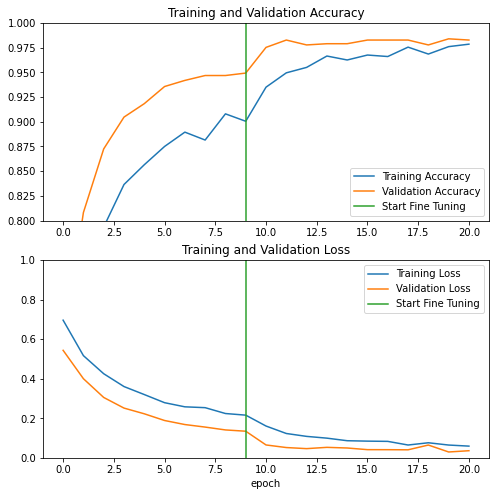

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 1s - loss: 0.1187 - accuracy: 0.9375

3/6 [==============>...............] - ETA: 0s - loss: 0.0446 - accuracy: 0.9792

5/6 [========================>.....] - ETA: 0s - loss: 0.0448 - accuracy: 0.9750

6/6 [==============================] - 1s 38ms/step - loss: 0.0428 - accuracy: 0.9740


Test accuracy : 0.9739583134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1]
Labels:
 [0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1]


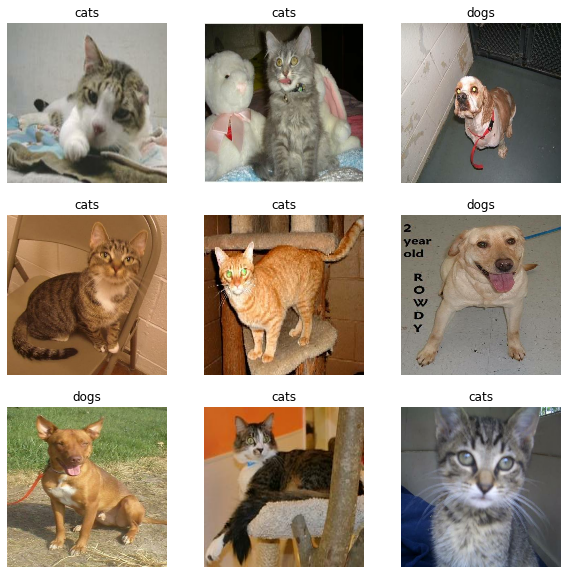

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
